# Absolute Positional Encoding

## The Problem: Permutation Invariance

The fundamental flaw of the pure Transformer architecture is that it is **Permutation Invariant**.

If you feed the sentence "The man bit the dog" into a Transformer without positional encodings, the attention mechanism sees it as a "bag of words": `{man, dog, bit, the}`. It has no way of knowing that "man" came before "bit". To the model, "The dog bit the man" looks mathematically identical.

**To fix this, we must inject "order" into the data before it even hits the first layer.**

## The Strategy: Addition, Not Concatenation

A common intuition is to simply append the position number to the vector:

- **Token Vector:** `[0.1, -0.5, ...]`
- **Position:** `1`
- **Concatenation:** `[0.1, -0.5, ..., 1]`

### Why we don't do this:

1. **Dimensions:** Concatenating changes the dimension size ($d_{model} + 1$).
2. **Magnitude:** If the sequence is long (e.g., 8,000 tokens), the position value `8000` will dominate the gradient, destroying the delicate token embeddings (which are usually between `-1` and `1`).

## The Solution: Element-wise Addition

We create a **Positional Vector** of the exact same size ($d_{model}$) as the token embedding and add them together element-wise:

$$x_{final} = x_{embedding} + x_{position}$$

Because the embedding space is high-dimensional (e.g., 512 dimensions), the model learns to separate the "semantic signal" from the "positional signal" within the same vector.

Input shape:  torch.Size([2, 10])
Output shape: torch.Size([2, 10, 512])
Success: Tokens converted to Position-Aware Vectors.


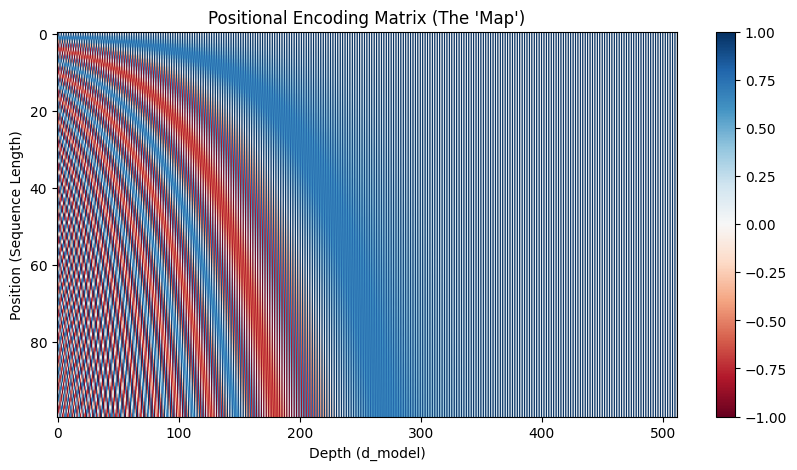

In [3]:
import torch
import torch.nn as nn
import math

class TransformerEmbedding(nn.Module):
    """
    Layer 0: Combines Token Embeddings and Positional Encoding.
    """
    def __init__(self, vocab_size, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        
        # 1. THE EMBEDDING (Token -> Vector)
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # 2. THE POSITIONAL ENCODING (The "Map")
        # Create a matrix of shape [max_len, d_model] to hold position vectors
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        
        # Calculate the wave frequencies (log space is more stable)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        # Fill the matrix: Sine for even indices, Cosine for odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add a batch dimension [1, max_len, d_model] so we can broadcast later
        pe = pe.unsqueeze(0)
        
        # Register as a buffer: It's part of the state_dict, but not trained by the optimizer
        self.register_buffer('pe', pe)
        
        # 3. DROPOUT (For regularization)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # x: [batch_size, seq_len] (e.g., [32, 10])
        
        # Step A: Get the vectors
        # output: [batch_size, seq_len, d_model]
        x = self.embedding(x)
        
        # Step B: Scale the vectors (Critical for Transformer stability)
        x = x * math.sqrt(self.d_model)
        
        # Step C: Add Position Info
        # We slice self.pe to match the actual sequence length of x
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        
        return self.dropout(x)

# --- DEMO ---

# 1. Setup Configuration
vocab_size = 10000   # Total words in dictionary
d_model = 512        # Vector size per word
max_len = 100        # Maximum sequence length

# 2. Initialize Layer
layer0 = TransformerEmbedding(vocab_size, d_model, max_len)

# 3. Create Dummy Data (Batch of 2 sentences, 10 words each)
input_ids = torch.randint(0, vocab_size, (2, 10))

# 4. Forward Pass
output = layer0(input_ids)

print(f"Input shape:  {input_ids.shape}") # [2, 10]
print(f"Output shape: {output.shape}")    # [2, 10, 512]
print("Success: Tokens converted to Position-Aware Vectors.")

# --- VISUALIZATION (Optional) ---
# This shows the 'map' the model uses to know where words are.
plt.figure(figsize=(10, 5))
plt.imshow(layer0.pe[0].numpy(), aspect='auto', cmap='RdBu')
plt.title("Positional Encoding Matrix (The 'Map')")
plt.xlabel("Depth (d_model)")
plt.ylabel("Position (Sequence Length)")
plt.colorbar()
plt.show()